<center><img src="http://i.imgur.com/sSaOozN.png" width="500"></center>

## Course: Computational Thinking for Governance Analytics

### Prof. José Manuel Magallanes, PhD 
* Visiting Professor of Computational Policy at Evans School of Public Policy and Governance, and eScience Institute Senior Data Science Fellow, University of Washington.
* Professor of Government and Political Methodology, Pontificia Universidad Católica del Perú. 

_____

<a id='home'></a>

# Data Preprocessing in Python: Data Integration and Reshaping

I will cover some important processes for DFs:
* [Appending](#appending)
* [Reshaping](#reshaping)
* [Merging](#merging)

Finally, we will see some simple code for:
* [Scaling](#scaling)
* [Exporting](#exporting)

<a id='appending'></a>

# Appending

As the name implies, this process binds DFs into one, that is, one or more DFs will be put below or on top of another DF. Appending can be done when you fulfill these requisites:
1. All the DFs  share the same column names.
2. All the DFs  columns are in the same location.
2. All the DFs  columns have the same data types.

Let's visit this website: https://fundforpeace.org/what-we-do/country-risk-and-fragility-data/

There, you will find several excel files with the _Fragile States Index_ per year. Let's downloan the ones for years 2019-2021 in the folder where this notebook is stored. Then, we can open them:

In [1]:
import pandas as pd

file2021="fsi-2021.xlsx"
file2020="fsi-2020.xlsx"
file2019="fsi-2019.xlsx"
    

# fetching the tables
fragil2021=pd.read_excel(file2021)
fragil2020=pd.read_excel(file2020)
fragil2019=pd.read_excel(file2019)

The goal is to append all of them. 

In the next operations, I will use **sets**. Let me show you how they work with simple examples:

In [2]:
A=['a','b','c']
B=['a','b','d','c']
C=['a','b','e','g']

# set intersection
set(A) & set(B) & set(C)

{'a', 'b'}

Then, using set I can verify that condition 1 is fulfilled:

In [3]:
# these are the columns shared among the DFs
set(fragil2021.columns)&set(fragil2020)&set(fragil2019)

{'C1: Security Apparatus',
 'C2: Factionalized Elites',
 'C3: Group Grievance',
 'Country',
 'E1: Economy',
 'E2: Economic Inequality',
 'E3: Human Flight and Brain Drain',
 'P1: State Legitimacy',
 'P2: Public Services',
 'P3: Human Rights',
 'Rank',
 'S1: Demographic Pressures',
 'S2: Refugees and IDPs',
 'Total',
 'X1: External Intervention',
 'Year'}

This intersection is offering me a particular order, then you can create DFs with columns located in that same order, which will allow us to fulfill the second condition:

In [4]:
common=set(fragil2021.columns)&set(fragil2020)&set(fragil2019)

# we are keeping just the 'common' columns:
fragil2021ap=fragil2021.loc[:,common]
fragil2020ap=fragil2020.loc[:,common]
fragil2019ap=fragil2019.loc[:,common]

The last requisite is to make sure they share the same data types. Let's check the data types with the help of **zip**, **set** and **len**:

In [5]:
A=['a','b','c']
B=['a','b','c']
C=['a','b','d']

# zip will pair elements in the same position:
list(zip(A,B,C))

[('a', 'a', 'a'), ('b', 'b', 'b'), ('c', 'c', 'd')]

Combining _len_ and _set_ you have a measure of 'variety'. If variety of a _set_ equals **1**, all the elements in a _set_ are the same:

In [6]:
len(set([1,1,1,1,1,1,1,1,1,1])), \
len(set([1,2,1])), \
len(set([1,111,11]))

(1, 2, 3)

Then, you detect where a group does not have the same elements, that is, where the set size offers a variety greater than one:

In [7]:
# check if every zipped group has a variety greater than 1.
[x for x in zip(A,B,C) if len(set(x))>1]

[('c', 'c', 'd')]

Applying that to our case:

In [8]:
# 1. the zipped data types:
theZips=zip(fragil2021ap.dtypes,
            fragil2020ap.dtypes,
            fragil2019ap.dtypes)
# you see:
list(theZips)

[(dtype('int64'), dtype('<M8[ns]'), dtype('<M8[ns]')),
 (dtype('O'), dtype('O'), dtype('O')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('O'), dtype('O'), dtype('O')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64')),
 (dtype('float64'), dtype('float64'), dtype('float64'))]

In [9]:
# 2. computing the variety in each case above:
theZips=zip(fragil2021ap.dtypes,
            fragil2020ap.dtypes,
            fragil2019ap.dtypes) # why again? zip is generator
[x for x in theZips if len(set(x))>1]

[(dtype('int64'), dtype('<M8[ns]'), dtype('<M8[ns]'))]

From the result above, there is one set of columns that share different data types. Let me modify the previous code to detect the location:

In [10]:
theZips=zip(fragil2021ap.dtypes.index,
            fragil2021ap.dtypes,
            fragil2020ap.dtypes,
            fragil2019ap.dtypes)

[x for x in theZips if len(set(x))>2]

[('Year', dtype('int64'), dtype('<M8[ns]'), dtype('<M8[ns]'))]

The Year is not an integer in the DFs for 2020 and 2019, it is **date** type. 

In [11]:
fragil2020ap['Year']

0     2020-01-01
1     2020-01-01
2     2020-01-01
3     2020-01-01
4     2020-01-01
         ...    
173   2020-01-01
174   2020-01-01
175   2020-01-01
176   2020-01-01
177   2020-01-01
Name: Year, Length: 178, dtype: datetime64[ns]

Using the **dt** attribute of a **date** column in Pandas, we can recover just the year as an integer:

In [12]:
fragil2020ap['Year']=fragil2020ap['Year'].dt.year
fragil2019ap['Year']=fragil2019ap['Year'].dt.year

Now it should be fine:

In [13]:
# if empty list, all dtypes are the same
theZips=zip(fragil2021ap.dtypes,fragil2020ap.dtypes,fragil2019ap.dtypes)
[x for x in theZips if len(set(x))>1]

[]

As we have met al the requisites, let's do the appending!

In [14]:
fragile=pd.concat([fragil2021ap,fragil2020ap,fragil2019ap])
fragile

,Year,Country,E1: Economy,E3: Human Flight and Brain Drain,Rank,S2: Refugees and IDPs,X1: External Intervention,Total,C2: Factionalized Elites,C1: Security Apparatus,E2: Economic Inequality,P1: State Legitimacy,S1: Demographic Pressures,P2: Public Services,P3: Human Rights,C3: Group Grievance
0,2021,Yemen,9.8,6.7,1st,9.8,9.7,111.7,10.0,9.4,7.7,9.9,9.8,9.8,9.7,9.4
1,2021,Somalia,9.2,8.8,2nd,9.2,8.9,110.9,10.0,9.3,9.5,9.2,10.0,9.8,8.7,8.3
2,2021,Syria,9.6,8.2,3rd,9.7,10.0,110.7,9.9,9.6,7.1,10.0,7.6,9.6,9.7,9.7
3,2021,South Sudan,9.2,6.7,4th,9.9,9.3,109.4,9.2,9.7,8.9,9.5,9.5,10.0,8.7,8.8
4,2021,Congo Democratic Republic,8.5,6.8,5th,10.0,9.1,108.4,9.5,8.6,8.5,9.2,9.8,9.8,9.2,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2019,Australia,1.6,1.0,174th,1.7,0.7,19.7,1.7,2.7,1.6,1.0,1.2,1.5,1.7,3.3
174,2019,Denmark,1.6,1.9,175th,2.0,0.7,19.5,1.4,1.3,1.2,0.9,1.6,0.9,1.7,4.3
175,2019,Switzerland,1.9,1.7,176th,2.7,0.7,18.7,1.0,1.1,1.8,0.7,1.4,1.0,1.4,3.3
176,2019,Norway,1.9,1.3,177th,2.8,1.0,18.0,1.1,2.1,1.0,0.6,1.2,0.8,0.9,3.3


You may notice that the column ordering does not look nice, as in general you expect that the columns to the left start with identification of the rows rather than some measurements; then, let's move 'Country','Year','Total' to the left:

In [15]:
# this is a trick: setting columns as index
fragile.set_index(['Country','Year','Total'],inplace=True)
fragile

,,,E1: Economy,E3: Human Flight and Brain Drain,Rank,S2: Refugees and IDPs,X1: External Intervention,C2: Factionalized Elites,C1: Security Apparatus,E2: Economic Inequality,P1: State Legitimacy,S1: Demographic Pressures,P2: Public Services,P3: Human Rights,C3: Group Grievance
Country,Year,Total,,,,,,,,,,,,,
Yemen,2021,111.7,9.8,6.7,1st,9.8,9.7,10.0,9.4,7.7,9.9,9.8,9.8,9.7,9.4
Somalia,2021,110.9,9.2,8.8,2nd,9.2,8.9,10.0,9.3,9.5,9.2,10.0,9.8,8.7,8.3
Syria,2021,110.7,9.6,8.2,3rd,9.7,10.0,9.9,9.6,7.1,10.0,7.6,9.6,9.7,9.7
South Sudan,2021,109.4,9.2,6.7,4th,9.9,9.3,9.2,9.7,8.9,9.5,9.5,10.0,8.7,8.8
Congo Democratic Republic,2021,108.4,8.5,6.8,5th,10.0,9.1,9.5,8.6,8.5,9.2,9.8,9.8,9.2,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Australia,2019,19.7,1.6,1.0,174th,1.7,0.7,1.7,2.7,1.6,1.0,1.2,1.5,1.7,3.3
Denmark,2019,19.5,1.6,1.9,175th,2.0,0.7,1.4,1.3,1.2,0.9,1.6,0.9,1.7,4.3
Switzerland,2019,18.7,1.9,1.7,176th,2.7,0.7,1.0,1.1,1.8,0.7,1.4,1.0,1.4,3.3


Since I will not use _Rank_, I will get rid of it:

In [16]:
fragile.drop(columns='Rank',inplace=True)
fragile

,,,E1: Economy,E3: Human Flight and Brain Drain,S2: Refugees and IDPs,X1: External Intervention,C2: Factionalized Elites,C1: Security Apparatus,E2: Economic Inequality,P1: State Legitimacy,S1: Demographic Pressures,P2: Public Services,P3: Human Rights,C3: Group Grievance
Country,Year,Total,,,,,,,,,,,,
Yemen,2021,111.7,9.8,6.7,9.8,9.7,10.0,9.4,7.7,9.9,9.8,9.8,9.7,9.4
Somalia,2021,110.9,9.2,8.8,9.2,8.9,10.0,9.3,9.5,9.2,10.0,9.8,8.7,8.3
Syria,2021,110.7,9.6,8.2,9.7,10.0,9.9,9.6,7.1,10.0,7.6,9.6,9.7,9.7
South Sudan,2021,109.4,9.2,6.7,9.9,9.3,9.2,9.7,8.9,9.5,9.5,10.0,8.7,8.8
Congo Democratic Republic,2021,108.4,8.5,6.8,10.0,9.1,9.5,8.6,8.5,9.2,9.8,9.8,9.2,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Australia,2019,19.7,1.6,1.0,1.7,0.7,1.7,2.7,1.6,1.0,1.2,1.5,1.7,3.3
Denmark,2019,19.5,1.6,1.9,2.0,0.7,1.4,1.3,1.2,0.9,1.6,0.9,1.7,4.3
Switzerland,2019,18.7,1.9,1.7,2.7,0.7,1.0,1.1,1.8,0.7,1.4,1.0,1.4,3.3


Now put the row indexes back:

In [17]:
fragile.reset_index(inplace=True)
fragile

,Country,Year,Total,E1: Economy,E3: Human Flight and Brain Drain,S2: Refugees and IDPs,X1: External Intervention,C2: Factionalized Elites,C1: Security Apparatus,E2: Economic Inequality,P1: State Legitimacy,S1: Demographic Pressures,P2: Public Services,P3: Human Rights,C3: Group Grievance
0,Yemen,2021,111.7,9.8,6.7,9.8,9.7,10.0,9.4,7.7,9.9,9.8,9.8,9.7,9.4
1,Somalia,2021,110.9,9.2,8.8,9.2,8.9,10.0,9.3,9.5,9.2,10.0,9.8,8.7,8.3
2,Syria,2021,110.7,9.6,8.2,9.7,10.0,9.9,9.6,7.1,10.0,7.6,9.6,9.7,9.7
3,South Sudan,2021,109.4,9.2,6.7,9.9,9.3,9.2,9.7,8.9,9.5,9.5,10.0,8.7,8.8
4,Congo Democratic Republic,2021,108.4,8.5,6.8,10.0,9.1,9.5,8.6,8.5,9.2,9.8,9.8,9.2,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Australia,2019,19.7,1.6,1.0,1.7,0.7,1.7,2.7,1.6,1.0,1.2,1.5,1.7,3.3
531,Denmark,2019,19.5,1.6,1.9,2.0,0.7,1.4,1.3,1.2,0.9,1.6,0.9,1.7,4.3
532,Switzerland,2019,18.7,1.9,1.7,2.7,0.7,1.0,1.1,1.8,0.7,1.4,1.0,1.4,3.3
533,Norway,2019,18.0,1.9,1.3,2.8,1.0,1.1,2.1,1.0,0.6,1.2,0.8,0.9,3.3


Let's do some cleaning on the column names:

In [18]:
fragile.columns=fragile.columns.str.replace(':|\s',"",regex=True)
#see
fragile.columns

Index(['Country', 'Year', 'Total', 'E1Economy', 'E3HumanFlightandBrainDrain',
       'S2RefugeesandIDPs', 'X1ExternalIntervention', 'C2FactionalizedElites',
       'C1SecurityApparatus', 'E2EconomicInequality', 'P1StateLegitimacy',
       'S1DemographicPressures', 'P2PublicServices', 'P3HumanRights',
       'C3GroupGrievance'],
      dtype='object')

Finally, let's check the format:

In [19]:
fragile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     535 non-null    object 
 1   Year                        535 non-null    int64  
 2   Total                       535 non-null    float64
 3   E1Economy                   535 non-null    float64
 4   E3HumanFlightandBrainDrain  535 non-null    float64
 5   S2RefugeesandIDPs           535 non-null    float64
 6   X1ExternalIntervention      535 non-null    float64
 7   C2FactionalizedElites       535 non-null    float64
 8   C1SecurityApparatus         535 non-null    float64
 9   E2EconomicInequality        535 non-null    float64
 10  P1StateLegitimacy           535 non-null    float64
 11  S1DemographicPressures      535 non-null    float64
 12  P2PublicServices            535 non-null    float64
 13  P3HumanRights               535 non

[Home](#home)

______

<a id='reshaping'></a>

# Reshaping

Data frames have have different shapes. Let me keep some columns from the last DF so you can notice something:

In [20]:
fragileLong=fragile.iloc[:,:3]
fragileLong

,Country,Year,Total
0,Yemen,2021,111.7
1,Somalia,2021,110.9
2,Syria,2021,110.7
3,South Sudan,2021,109.4
4,Congo Democratic Republic,2021,108.4
...,...,...,...
530,Australia,2019,19.7
531,Denmark,2019,19.5
532,Switzerland,2019,18.7
533,Norway,2019,18.0


The unit of analysis is country. Generally, we are used to see the  unit of analysis once in a column, but it is repeated above, as the country will appear for every year of measurement.

Also, pay attention to the **amount of rows**. There are 535 rows, then:

In [21]:
535/3

178.33333333333334

That is the amount of rows per data year, so something went wrong during the appending. The truth is that cleaning and formatting will be needed after complex operations like these.

What is your best guess on what went wrong?

Whatever it is, let me turn our **long** into **wide** shape:

In [22]:
# wide
fragileWide=pd.pivot_table(fragileLong,
               values='Total', # values to use
               index=['Country'], # unit of analysis
               columns=['Year']) # the values for NEW column
fragileWide

Year,2019,2020,2021
Country,,,
Afghanistan,105.0,102.901187,102.1
Albania,58.9,58.753811,59.0
Algeria,75.4,74.575183,73.6
Angola,87.8,87.320039,89.0
Antigua and Barbuda,54.4,52.062352,54.9
...,...,...,...
Venezuela,89.3,91.157591,92.6
Vietnam,66.1,63.885397,63.3
Yemen,113.5,112.438694,111.7


The **wide** shape from a **pivot_table** function looks great, but pay attention:

In [23]:
fragileWide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2019    178 non-null    float64
 1   2020    178 non-null    float64
 2   2021    179 non-null    float64
dtypes: float64(3)
memory usage: 5.8+ KB


As you see above, the country is an _index_, not a column. This is important if you are planing to export this DF. Also, notice that the column names have a title (_Year_). So in general, you can use this code after the *pivot_table* function:

In [24]:
fragileWide= fragileWide.reset_index(drop=False).\
             rename_axis(index=None, columns=None)

# result:

fragileWide

,Country,2019,2020,2021
0,Afghanistan,105.0,102.901187,102.1
1,Albania,58.9,58.753811,59.0
2,Algeria,75.4,74.575183,73.6
3,Angola,87.8,87.320039,89.0
4,Antigua and Barbuda,54.4,52.062352,54.9
...,...,...,...,...
181,Venezuela,89.3,91.157591,92.6
182,Vietnam,66.1,63.885397,63.3
183,Yemen,113.5,112.438694,111.7
184,Zambia,85.7,84.474129,84.9


I mentioned that something went wrong during the appending process. Here, we can discover it:

In [25]:
# what cells have missing values?
fragileWide[fragileWide.isna().any(axis=1)]

,Country,2019,2020,2021
27,Cabo Verde,NaN,NaN,64.2
31,Cape Verde,66.6,64.778171,NaN
45,Czech Republic,NaN,35.741616,NaN
46,Czechia,37.6,NaN,39.3
56,Eswatini,85.3,NaN,82.5
81,Israel,NaN,NaN,43.0
82,Israel and West Bank,76.5,75.123972,NaN
90,Kyrgyz Republic,76.2,73.929364,NaN
91,Kyrgyzstan,NaN,NaN,76.4
100,Macedonia,64.6,62.130864,NaN


As you can see, even though the data DFs were prepared by the same [organization](https://fundforpeace.org/), the DFs have country names that differ among them. Here we need some **manual** changes: 

In [26]:
# prepare changes as dict:
changes={"Cabo Verde": "Cape Verde",
"Czechia":"Czech Republic",
"Swaziland":"Eswatini",
"Israel and West Bank":"Israel",
"Kyrgyzstan":"Kyrgyz Republic",
"North Macedonia":"Macedonia",
"Slovakia": "Slovak Republic"}



Notice I had to make the changes in the long shape of the DF, so that the wide shape will work fine:

In [27]:
# make changes using 'replace':
fragileLong.Country.replace(to_replace=changes,inplace=True)

Let's redo the wide reshape:

In [28]:
# wide
fragileWide=pd.pivot_table(fragileLong,
               values='Total',
               index=['Country'],
               columns=['Year']).\
            reset_index(drop=False).\
            rename_axis(index=None, columns=None)
##
fragileWide[fragileWide.isna().any(axis=1)]

,Country,2019,2020,2021
124,Palestine,NaN,NaN,86.0


You have to be very careful when working with countries, specially when you are including or excluding countries; which may cause you hurting someone else's feelings. 

For instance, here I am just keeping **rows** with no missing values:

In [29]:
fragileWide.dropna(inplace=True) # axis=1 for columns
fragileWide

,Country,2019,2020,2021
0,Afghanistan,105.0,102.901187,102.1
1,Albania,58.9,58.753811,59.0
2,Algeria,75.4,74.575183,73.6
3,Angola,87.8,87.320039,89.0
4,Antigua and Barbuda,54.4,52.062352,54.9
...,...,...,...,...
174,Venezuela,89.3,91.157591,92.6
175,Vietnam,66.1,63.885397,63.3
176,Yemen,113.5,112.438694,111.7
177,Zambia,85.7,84.474129,84.9


Also, notice that the final line above says that the last row index is 178; which means there are 179 rows. To correct that, reset the index:

In [30]:
fragileWide.reset_index(drop=True, inplace=True)
fragileWide

,Country,2019,2020,2021
0,Afghanistan,105.0,102.901187,102.1
1,Albania,58.9,58.753811,59.0
2,Algeria,75.4,74.575183,73.6
3,Angola,87.8,87.320039,89.0
4,Antigua and Barbuda,54.4,52.062352,54.9
...,...,...,...,...
173,Venezuela,89.3,91.157591,92.6
174,Vietnam,66.1,63.885397,63.3
175,Yemen,113.5,112.438694,111.7
176,Zambia,85.7,84.474129,84.9


For sure, we can turn this wide format into a long one, using the function **melt**:

In [31]:
pd.melt(fragileWide, id_vars=['Country'])

,Country,variable,value
0,Afghanistan,2019,105.0
1,Albania,2019,58.9
2,Algeria,2019,75.4
3,Angola,2019,87.8
4,Antigua and Barbuda,2019,54.4
...,...,...,...
529,Venezuela,2021,92.6
530,Vietnam,2021,63.3
531,Yemen,2021,111.7
532,Zambia,2021,84.9


This would be more explicit:

In [32]:
pd.melt(fragileWide, #DF
        id_vars=['Country'], #key
        value_vars=[2019,2020,2021], # columns in wide
        var_name='Year', # new name for long column
        value_name='Total')# new name for values

,Country,Year,Total
0,Afghanistan,2019,105.0
1,Albania,2019,58.9
2,Algeria,2019,75.4
3,Angola,2019,87.8
4,Antigua and Barbuda,2019,54.4
...,...,...,...
529,Venezuela,2021,92.6
530,Vietnam,2021,63.3
531,Yemen,2021,111.7
532,Zambia,2021,84.9


[Home](#home)

______

<a id='merging'></a>

# Merging

Merging data sets need the following considerations:

* Merging is done on two data frames.
* You need a column in each data frame that share the same exact and unique values. The column names or titles need not be the same.
* The merged table shows by default the mutual coincidences; but you can also request the values not matched, which will help you detect possible extra cleaning.
* Pandas differentiates the **left** from the **right** data frames: **left**.merge(**right**).

At this stage, let me use two data frames to show how this works:

In [33]:
demo=pd.read_pickle("https://github.com/EvansDataScience/CTforGA_cleaning/raw/main/demoindex.pkl")
#and
fragile2021=fragile[fragile.Year==2021].drop(columns=['Year'])

Remember the amount of rows of each DF:

In [34]:
demo.shape,fragile2021.shape

((167, 8), (179, 14))

Let me show you some merge approaches, but only the amount of columns produced:

1. You keep only what is common in both key columns:

This is the default. The final rows will be the ones where the key values in each data frame match exactly. In this case, your count of rows will be at most the amount of rows of the smallest data frame.

In [35]:
fragile2021.merge(demo).shape  # how=inner - this is the default 

(158, 21)

2. You keep all the keys from the left/right:

The final rows will be all the rows from the dataframe from the left. If a key values does not find a match, the key value is kept, but the columns will have missing values. In this case, your count of rows will be equal to the amount of rows of the data frame to the left. You can also use **right** so the same logic applies to the data frame to the right.



In [36]:
fragile2021.merge(demo, how='left').shape

(179, 21)

In [37]:
fragile2021.merge(demo, how='right').shape

(167, 21)

3. You keep all the rows from both data frames:

In this case you will obtain all possible rows: the matched values, and the unmatched values from both data frames. You will also generate missing values. In this case, your count of rows will be at least the amount of rows of the data frame with the most rows.


In [38]:
fragile2021.merge(demo, how='outer').shape

(188, 21)

Let's use the default case for now. 

In [39]:
demo.merge(fragile2021)

,Country,Regimetype,Overallscore,Electoralprocessandpluralism,Functioningofgovernment,Politicalparticipation,Politicalculture,Civilliberties,Total,E1Economy,...,S2RefugeesandIDPs,X1ExternalIntervention,C2FactionalizedElites,C1SecurityApparatus,E2EconomicInequality,P1StateLegitimacy,S1DemographicPressures,P2PublicServices,P3HumanRights,C3GroupGrievance
0,Norway,Full democracy,9.75,10.00,9.64,10.00,10.00,9.12,16.6,1.9,...,2.2,0.5,1.1,1.8,1.0,0.5,1.4,1.6,0.5,3.3
1,New Zealand,Full democracy,9.37,10.00,8.93,9.44,8.75,9.71,18.4,3.4,...,1.6,0.5,1.4,1.4,2.1,0.5,1.4,1.4,0.5,2.6
2,Finland,Full democracy,9.27,10.00,9.29,8.89,8.75,9.41,16.2,2.9,...,1.5,0.5,1.4,2.5,1.0,0.5,1.7,1.6,0.5,0.6
3,Sweden,Full democracy,9.26,9.58,9.29,8.33,10.00,9.12,21.4,1.9,...,4.3,0.5,1.8,2.7,1.7,0.5,3.3,1.4,0.9,1.7
4,Iceland,Full democracy,9.18,10.00,8.21,8.89,9.38,9.41,18.0,3.4,...,1.5,3.2,1.8,0.7,1.3,0.5,1.5,1.2,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,Syria,Authoritarian,1.43,0.00,0.00,2.78,4.38,0.00,110.7,9.6,...,9.7,10.0,9.9,9.6,7.1,10.0,7.6,9.6,9.7,9.7
154,Central African Republic,Authoritarian,1.43,1.25,0.00,1.67,1.88,2.35,107.0,8.5,...,9.7,9.6,9.7,8.0,9.6,9.0,8.9,10.0,9.3,8.1
155,North Korea,Authoritarian,1.08,0.00,2.50,1.67,1.25,0.00,90.0,8.9,...,3.8,9.2,8.8,8.0,7.3,9.9,7.1,8.6,9.4,5.2
156,Myanmar,Authoritarian,1.02,0.00,0.00,1.67,3.13,0.29,93.8,4.8,...,8.8,7.1,8.3,8.9,7.1,8.1,6.3,8.9,9.1,9.9


As you see less rows than the data frame with the least rows, you wnt to know **what does not match** between the key columns. Let's use set operations to find what countries are not matching:

In [40]:
# Countris in 'demo' but NOT in 'fragile2021' 
OnlyDemo=set(demo.Country)-set(fragile2021.Country)
OnlyDemo

{'Cape Verde',
 'Czech Republic',
 'Democratic Republic of the Congo',
 'East Timor',
 'Guinea-Bissau',
 'Hong Kong',
 'Ivory Coast',
 'Republic of the Congo',
 'Taiwan'}

In [41]:
# Countris in 'fragile2021' but NOT in 'demo' 
OnlyFragile=set(fragile2021.Country)-set(demo.Country)
OnlyFragile

{'Antigua and Barbuda',
 'Bahamas',
 'Barbados',
 'Belize',
 'Brunei Darussalam',
 'Cabo Verde',
 'Congo Democratic Republic',
 'Congo Republic',
 "Cote d'Ivoire",
 'Czechia',
 'Grenada',
 'Guinea Bissau',
 'Maldives',
 'Micronesia',
 'Samoa',
 'Sao Tome and Principe',
 'Seychelles',
 'Solomon Islands',
 'Somalia',
 'South Sudan',
 'Timor-Leste'}

Here, we should try to find the what countries in _OnlyFragile_ may match the ones in _OnlyDemo_. We need to use the **fuzzy merge** approach (please install **thefuzz** if not previously installed):

In [42]:
from thefuzz import process as fz

# take a country from OnlyDemo
# look for a country in OnlyFragile and return the most similar
[(fz.extractOne(demo, OnlyFragile),demo) for demo in sorted(OnlyDemo)]

[(('Cabo Verde', 80), 'Cape Verde'),
 (('Congo Democratic Republic', 86), 'Czech Republic'),
 (('Congo Democratic Republic', 95), 'Democratic Republic of the Congo'),
 (('Timor-Leste', 82), 'East Timor'),
 (('Guinea Bissau', 100), 'Guinea-Bissau'),
 (('Congo Democratic Republic', 50), 'Hong Kong'),
 (("Cote d'Ivoire", 64), 'Ivory Coast'),
 (('Congo Republic', 86), 'Republic of the Congo'),
 (('Somalia', 46), 'Taiwan')]

Above you have found _some_ good matches. As you see the ones that are wrong have  less than 95% match. Let's just keep those:

In [43]:
[(fz.extractOne(demo, OnlyFragile),demo) 
 for demo in sorted(OnlyDemo) 
 if fz.extractOne(demo, OnlyFragile)[1]>=95]

[(('Congo Democratic Republic', 95), 'Democratic Republic of the Congo'),
 (('Guinea Bissau', 100), 'Guinea-Bissau')]

Once you have good matches, you have to create dictionary like this:

In [44]:
changesFragile1={fz.extractOne(demo, OnlyFragile)[0]:demo 
                 for demo in sorted(OnlyDemo) 
                 if fz.extractOne(demo, OnlyFragile)[1]>=95}
#dict of matches
changesFragile1

{'Congo Democratic Republic': 'Democratic Republic of the Congo',
 'Guinea Bissau': 'Guinea-Bissau'}

You can use that dict for the replacements:

In [45]:
fragile2021.Country.replace(to_replace=changesFragile1,inplace=True)

Now the countries in fragile2021 have more matches. 

This process can be done a few more times, and you can recover more rows for the merging process. Let's see:

In [46]:
# second try
OnlyDemo=set(demo.Country)-set(fragile2021.Country)
OnlyFragile=set(fragile2021.Country)-set(demo.Country)
[(fz.extractOne(demo, OnlyFragile),demo) for demo in sorted(OnlyDemo)]

[(('Cabo Verde', 80), 'Cape Verde'),
 (('Congo Republic', 71), 'Czech Republic'),
 (('Timor-Leste', 82), 'East Timor'),
 (('Antigua and Barbuda', 40), 'Hong Kong'),
 (("Cote d'Ivoire", 64), 'Ivory Coast'),
 (('Congo Republic', 86), 'Republic of the Congo'),
 (('Somalia', 46), 'Taiwan')]

In [47]:
# second dict of changes
# select a different threshold
changesFragile2={fz.extractOne(demo, OnlyFragile)[0]:demo 
                 for demo in sorted(OnlyDemo) 
                 if fz.extractOne(demo, OnlyFragile)[1]>=80}
#dict of matches
changesFragile2

{'Cabo Verde': 'Cape Verde',
 'Timor-Leste': 'East Timor',
 'Congo Republic': 'Republic of the Congo'}

In [48]:
# make the changes
fragile2021.Country.replace(to_replace=changesFragile2,inplace=True)

In [49]:
# third try
OnlyDemo=set(demo.Country)-set(fragile2021.Country)
OnlyFragile=set(fragile2021.Country)-set(demo.Country)
[(fz.extractOne(demo, OnlyFragile),demo) for demo in sorted(OnlyDemo)]

[(('Czechia', 64), 'Czech Republic'),
 (('Solomon Islands', 40), 'Hong Kong'),
 (("Cote d'Ivoire", 64), 'Ivory Coast'),
 (('Somalia', 46), 'Taiwan')]

In [50]:
# third dict of changes
# new threshold
changesFragile3={fz.extractOne(demo, OnlyFragile)[0]:demo 
                 for demo in sorted(OnlyDemo) 
                 if fz.extractOne(demo, OnlyFragile)[1]>=64}
#dict of matches
changesFragile3

{'Czechia': 'Czech Republic', "Cote d'Ivoire": 'Ivory Coast'}

In [51]:
# make changes
fragile2021.Country.replace(to_replace=changesFragile3,inplace=True)

In [52]:
# fourth try

OnlyDemo=set(demo.Country)-set(fragile2021.Country)
OnlyFragile=set(fragile2021.Country)-set(demo.Country)
[(fz.extractOne(demo, OnlyFragile),demo) for demo in sorted(OnlyDemo)]

[(('Solomon Islands', 40), 'Hong Kong'), (('Somalia', 46), 'Taiwan')]

The fourth attempt did not offer good results. Those two countries will not be able to be matched. Let's retry the merge:

In [53]:
demo_fragile=demo.merge(fragile2021)

In [54]:
#checking:
demo_fragile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 164
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country                       165 non-null    object  
 1   Regimetype                    165 non-null    category
 2   Overallscore                  165 non-null    float64 
 3   Electoralprocessandpluralism  165 non-null    float64 
 4   Functioningofgovernment       165 non-null    float64 
 5   Politicalparticipation        165 non-null    float64 
 6   Politicalculture              165 non-null    float64 
 7   Civilliberties                165 non-null    float64 
 8   Total                         165 non-null    float64 
 9   E1Economy                     165 non-null    float64 
 10  E3HumanFlightandBrainDrain    165 non-null    float64 
 11  S2RefugeesandIDPs             165 non-null    float64 
 12  X1ExternalIntervention        165 non-null    floa

Merging is a key process for producing analytics. So, it is always good to add some 'standard' information to avoid the need of fuzzy merging. See this data table


In [55]:
isos='https://github.com/EvansDataScience/CTforGA_integrating/raw/main/isodata.csv'
isodata=pd.read_csv(isos)
isodata

,Countryname,Officialstatename,InternetccTLD,iso2,iso3
0,Afghanistan,The Islamic Republic of Afghanistan,.af,AF,AFG
1,Åland Islands,Åland,.ax,AX,ALA
2,Albania,The Republic of Albania,.al,AL,ALB
3,Algeria,The People's Democratic Republic of Algeria,.dz,DZ,DZA
4,American Samoa,The Territory of American Samoa,.as,AS,ASM
...,...,...,...,...,...
244,Wallis and Futuna,The Territory of the Wallis and Futuna Islands,.wf,WF,WLF
245,Western Sahara,The Sahrawi Arab Democratic Republic,NaN,EH,ESH
246,Yemen,The Republic of Yemen,.ye,YE,YEM
247,Zambia,The Republic of Zambia,.zm,ZM,ZMB


We should add the **ISO** columns to our recent merged data frame:

In [56]:
# key columns are not spelled the same:

isodata.merge(demo_fragile,right_on='Country', left_on='Countryname')

,Countryname,Officialstatename,InternetccTLD,iso2,iso3,Country,Regimetype,Overallscore,Electoralprocessandpluralism,Functioningofgovernment,...,S2RefugeesandIDPs,X1ExternalIntervention,C2FactionalizedElites,C1SecurityApparatus,E2EconomicInequality,P1StateLegitimacy,S1DemographicPressures,P2PublicServices,P3HumanRights,C3GroupGrievance
0,Afghanistan,The Islamic Republic of Afghanistan,.af,AF,AFG,Afghanistan,Authoritarian,0.32,0.00,0.07,...,8.8,8.3,8.6,10.0,8.1,8.7,9.0,9.8,7.4,7.2
1,Albania,The Republic of Albania,.al,AL,ALB,Albania,Flawed democracy,6.11,7.00,6.43,...,2.6,6.1,6.2,4.8,2.9,5.5,4.1,4.4,3.6,4.1
2,Algeria,The People's Democratic Republic of Algeria,.dz,DZ,DZA,Algeria,Authoritarian,3.77,3.08,2.50,...,6.8,3.7,7.5,6.0,5.6,7.8,4.8,5.6,6.3,7.2
3,Angola,The Republic of Angola,.ao,AO,AGO,Angola,Authoritarian,3.37,1.33,2.86,...,5.9,4.6,7.2,7.2,8.9,8.2,9.0,9.3,6.2,8.1
4,Argentina,The Argentine Republic,.ar,AR,ARG,Argentina,Flawed democracy,6.81,9.17,5.00,...,1.9,4.3,2.8,4.9,4.9,4.0,5.3,4.8,3.3,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Uruguay,The Oriental Republic of Uruguay,.uy,UY,URY,Uruguay,Full democracy,8.85,10.00,8.57,...,1.9,2.7,2.7,4.2,3.3,0.5,3.4,3.8,3.0,2.4
132,Uzbekistan,The Republic of Uzbekistan,.uz,UZ,UZB,Uzbekistan,Authoritarian,2.12,0.08,1.86,...,4.4,4.0,8.8,6.2,5.7,9.3,4.8,4.6,7.6,6.0
133,Yemen,The Republic of Yemen,.ye,YE,YEM,Yemen,Authoritarian,1.95,0.00,0.00,...,9.8,9.7,10.0,9.4,7.7,9.9,9.8,9.8,9.7,9.4
134,Zambia,The Republic of Zambia,.zm,ZM,ZMB,Zambia,Hybrid regime,5.72,7.50,3.64,...,5.5,6.8,5.9,4.5,9.3,7.5,9.4,8.0,7.0,5.3


It seems I need five more:

In [57]:
demo_fragile.shape

(165, 21)

Let;s find this time **ALL** the matches:

In [58]:
onlyDEF=set(demo_fragile.Country)-set(isodata.Countryname)
onlyISO=set(isodata.Countryname)-set(demo_fragile.Country)

[(demo,fz.extract(demo, onlyISO)) for demo in sorted(onlyDEF)]

[('Bolivia',
  [('Bolivia (Plurinational State of)', 90),
   ('Venezuela (Bolivarian Republic of)', 77),
   ('Somalia', 57),
   ('Dominica', 53),
   ('Dominican Republic (the)', 51)]),
 ('Cape Verde',
  [('Cabo Verde', 80),
   ("Côte d'Ivoire", 55),
   ('Korea (the Republic of)', 45),
   ('Dominican Republic (the)', 45),
   ('British Indian Ocean Territory (the)', 45)]),
 ('Central African Republic',
  [('Central African Republic (the)', 95),
   ("Korea (the Democratic People's Republic of)", 86),
   ("Lao People's Democratic Republic (the)", 86),
   ('Congo (the Democratic Republic of the)', 86),
   ('Syrian Arab Republic (the)', 64)]),
 ('Comoros',
  [('Comoros (the)', 90),
   ('Cocos (Keeling) Islands (the)', 51),
   ('Timor-Leste', 51),
   ('Micronesia (Federated States of)', 51),
   ('United States Minor Outlying Islands (the)', 51)]),
 ('Czech Republic',
  [('Iran (Islamic Republic of)', 86),
   ('Korea (the Republic of)', 86),
   ('Tanzania, the United Republic of', 86),
   ('Do

Let's prepare manually the dictionary of replacements:


In [59]:
moreChanges={'Czech Republic':'Czechia',
             'Laos':"Lao People's Democratic Republic (the)",
             'North Korea':"Korea (the Democratic People's Republic of)",
             'Republic of the Congo':'Congo (the)',
             'South Korea':'Korea (the Republic of)'}
demo_fragile.Country.replace(to_replace=moreChanges,inplace=True)
# merging
demfragiso=isodata.merge(demo_fragile,
                         right_on='Country',
                         left_on='Countryname')

Pay attention to this:

In [60]:
demfragiso.columns

Index(['Countryname', 'Officialstatename', 'InternetccTLD', 'iso2', 'iso3',
       'Country', 'Regimetype', 'Overallscore', 'Electoralprocessandpluralism',
       'Functioningofgovernment', 'Politicalparticipation', 'Politicalculture',
       'Civilliberties', 'Total', 'E1Economy', 'E3HumanFlightandBrainDrain',
       'S2RefugeesandIDPs', 'X1ExternalIntervention', 'C2FactionalizedElites',
       'C1SecurityApparatus', 'E2EconomicInequality', 'P1StateLegitimacy',
       'S1DemographicPressures', 'P2PublicServices', 'P3HumanRights',
       'C3GroupGrievance'],
      dtype='object')

Notice that you have this:

In [61]:
demfragiso.loc[:,['Countryname','Country']]

,Countryname,Country
0,Afghanistan,Afghanistan
1,Albania,Albania
2,Algeria,Algeria
3,Angola,Angola
4,Argentina,Argentina
...,...,...
136,Uruguay,Uruguay
137,Uzbekistan,Uzbekistan
138,Yemen,Yemen
139,Zambia,Zambia


We could get rid of the repeated column:

In [62]:
demfragiso.drop(columns=['Country'],inplace=True)

[Home](#home)


______

<a id='scaling'></a>


# Data Scaling

It all look great so far. However, once you think you have the data ready, you should see the data ranges:

In [63]:
demfragiso.describe(include='all')

,Countryname,Officialstatename,InternetccTLD,iso2,iso3,Regimetype,Overallscore,Electoralprocessandpluralism,Functioningofgovernment,Politicalparticipation,...,S2RefugeesandIDPs,X1ExternalIntervention,C2FactionalizedElites,C1SecurityApparatus,E2EconomicInequality,P1StateLegitimacy,S1DemographicPressures,P2PublicServices,P3HumanRights,C3GroupGrievance
count,141,141,141,140,141,141,141.000000,141.000000,141.000000,141.000000,...,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
unique,141,141,141,140,141,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Papua New Guinea,The Republic of Costa Rica,.kp,RW,BGD,Authoritarian,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,1,1,47,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,5.390638,5.858723,4.788369,5.405887,...,4.692199,4.956028,6.397872,5.136879,5.151773,5.616312,5.731915,5.587234,5.253901,5.682979
std,NaN,NaN,NaN,NaN,NaN,NaN,2.285746,3.786163,2.535542,1.946057,...,2.300530,2.415733,2.471075,2.289679,2.195242,2.885868,2.258328,2.494876,2.591125,2.347003
min,NaN,NaN,NaN,NaN,NaN,NaN,0.320000,0.000000,0.000000,0.000000,...,0.700000,0.500000,1.000000,0.500000,1.000000,0.500000,1.400000,1.200000,0.500000,0.500000
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.400000,1.670000,2.860000,3.890000,...,2.700000,3.200000,4.700000,3.300000,3.300000,3.600000,3.900000,3.700000,3.300000,3.900000
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.720000,7.420000,5.000000,5.560000,...,4.200000,5.200000,7.100000,5.300000,5.100000,6.300000,5.300000,5.200000,5.700000,5.700000
75%,NaN,NaN,NaN,NaN,NaN,NaN,7.160000,9.170000,6.430000,6.670000,...,6.800000,6.900000,8.300000,6.800000,7.000000,8.000000,7.700000,7.700000,7.300000,7.500000


The **describe** will only show numerical stats by default, so you need the parameter _include_ set to *all*. However, for our case, we should just request the range:

In [64]:
demfragiso.describe().loc[['min','max']].T # notice the transposing:

,min,max
Overallscore,0.32,9.75
Electoralprocessandpluralism,0.00,10.00
Functioningofgovernment,0.00,9.64
Politicalparticipation,0.00,10.00
Politicalculture,1.25,10.00
Civilliberties,0.00,9.71
Total,16.20,111.70
E1Economy,1.20,9.80
E3HumanFlightandBrainDrain,0.50,9.00
S2RefugeesandIDPs,0.70,9.80


A boxplot may also be helpful:

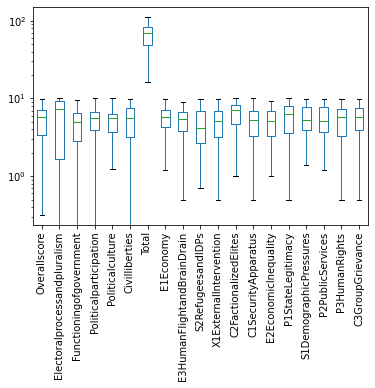

In [65]:
import matplotlib.pyplot as plt

demfragiso.plot(kind='box', rot=90)
plt.semilogy();

As you see above, the **Total** has a range of values different than the rest. Let's make sure all numeric columns share the same range:

In [66]:
from sklearn import preprocessing

# prepare the process
scaler = preprocessing.MinMaxScaler(feature_range=(0, 10))
# scaler = preprocessing.MinMaxScaler() default is 0 to 1

# apply process
columnsToScale=['Total'] # you can add more columns
scaledResult = scaler.fit_transform(demfragiso[columnsToScale])

# result
scaledResult

array([[ 8.9947644 ],
       [ 4.48167539],
       [ 6.0104712 ],
       [ 7.62303665],
       [ 3.54973822],
       [ 5.61256545],
       [ 0.58638743],
       [ 1.03664921],
       [ 6.16753927],
       [ 5.28795812],
       [ 7.20418848],
       [ 5.42408377],
       [ 1.54973822],
       [ 5.92670157],
       [ 5.45549738],
       [ 5.93717277],
       [ 4.27225131],
       [ 6.2408377 ],
       [ 3.70680628],
       [ 7.42408377],
       [ 8.47120419],
       [ 6.7434555 ],
       [ 8.48167539],
       [ 0.57591623],
       [ 9.38219895],
       [ 2.92146597],
       [ 5.51832461],
       [ 6.60732984],
       [ 7.97905759],
       [ 2.7539267 ],
       [ 3.51832461],
       [ 4.53403141],
       [ 4.31413613],
       [ 2.41884817],
       [ 0.27225131],
       [ 6.93193717],
       [ 5.7591623 ],
       [ 7.20418848],
       [ 5.80104712],
       [ 7.10994764],
       [ 8.46073298],
       [ 2.43979058],
       [ 6.94240838],
       [ 8.67015707],
       [ 5.67539267],
       [ 0

You just got:

In [67]:
type(scaledResult)

numpy.ndarray

Let me use that array to replace my values in the pandas _Series_:

In [68]:
demfragiso.Total=scaledResult

Now, these are my new data values:

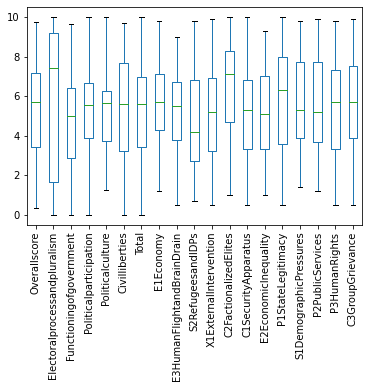

In [69]:
demfragiso.plot(kind='box', rot=90);

An alternative would have been to create a new column, so that you can keep the old value instead of overwriting it.

In [70]:
#demfragiso['Total_mM']=scaledResult

The data is ready to be exported.

In [71]:
demfragiso_expo=demfragiso.copy()


[Home](#home)


______

<a id='exporting'></a>


# Exporting file

The current *demo_fragile* data frame is clean and formatted. It is time to send it to a format that will keep all our work for future use.

#### For future use in Python:

In [ ]:
demfragiso_expo.to_pickle("demfragiso_expo.pkl")
# you will need: DF=pd.read_pickle("demfragiso_expo.pkl")
# or:
# from urllib.request import urlopen
# DF=pd.read_pickle(urlopen("https://..../demfragiso_expo.pkl"),compression=None)

#### For future  use in R:

In [72]:
#try the following before starting Python:
#export LD_LIBRARY_PATH="$(python -m rpy2.situation LD_LIBRARY_PATH)":${LD_LIBRARY_PATH}

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects.packages import importr

base = importr('base')
base.saveRDS(demfragiso_expo,file="demfragiso_expo.RDS")


#In R, you call it with: DF = readRDS("demfragiso_expo.RDS")
#or, if iyou read from cloud: DF = readRDS(url("https://..../demfragiso_expo.RDS")

<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff0ece995a0> [RTYPES.NILSXP]